In [1]:
#pip install torch torchvision numpy pandas opencv-python scikit-learn

In [2]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
IMG_SIZE = (512, 512)
BATCH_SIZE = 8
NUM_CLASSES = 14
NUM_EPOCHS = 10
LR = 5e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_DIR_TRAIN = '/kaggle/input/grand-xray-slam-division-b/train2/'
SAMPLE_SUBMISSION_CSV = '/kaggle/input/grand-xray-slam-division-b/sample_submission_2.csv'

In [4]:
# load train.csv
try:
    train_df = pd.read_csv('/kaggle/input/grand-xray-slam-division-b/train2.csv')
    print(f"Loaded train1.csv with {len(train_df)} rows")
except FileNotFoundError:
    print("Error: train1.csv not found. Ensure dataset is attached.")
    raise

label_columns = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
    'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
    'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
]

missing_cols = [col for col in label_columns if col not in train_df.columns]
if missing_cols:
    raise KeyError(f"Missing columns: {missing_cols}")

subset_frac = 0.2
df_small = train_df.sample(frac=subset_frac, random_state=42)

# split into train and validation 80/20
train_data, val_data = train_test_split(df_small, test_size=0.2, random_state=42)

print(f"Train samples: {len(train_data)}, Validation samples: {len(val_data)}")

Loaded train1.csv with 108494 rows
Train samples: 17359, Validation samples: 4340


In [ ]:
pos_counts = train_data[label_columns].sum(axis=0).values  # count 1s for each class
neg_counts = len(train_data) - pos_counts                  # count 0s for each class

pos_weight = torch.tensor(neg_counts / (pos_counts + 1e-5), dtype=torch.float32).to(DEVICE)

print("pos_weight:", pos_weight)

pos_weight: tensor([ 1.7230,  2.0012,  2.5748,  2.8774,  1.8044,  6.3400,  7.4185,  1.1553,
         2.2765,  2.0653, 13.7988,  6.2329, 11.8111,  1.8707], device='cuda:0')


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.LongestMaxSize(max_size=512),   # preserve proportions, reduce long side
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, value=0),  
    
    A.HorizontalFlip(p=0.5),          # flips
    A.ShiftScaleRotate(
        shift_limit=0.02, scale_limit=0.05, rotate_limit=5, 
        border_mode=0, value=0, p=0.3
    ),  # small shifts/scales/angles
    
    A.RandomBrightnessContrast(
        brightness_limit=0.05, contrast_limit=0.05, p=0.3
    ),  # light correction
    
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.2),  # soft contrast enhancement
    
    A.Normalize(mean=(0.5,), std=(0.5,)),  
    ToTensorV2()
])

val_transform = A.Compose([
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, value=0),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

/tmp/ipykernel_36/1914071829.py:6: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, value=0),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_36/1914071829.py:9: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_36/1914071829.py:26: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, value=0),


In [8]:
class ChestXRayDataset(Dataset):
    def __init__(self, df: pd.DataFrame, image_dir: str, img_size=IMG_SIZE, 
                             is_test=False, label_cols=None, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.img_size = img_size
        self.is_test = is_test
        self.label_cols = label_cols
        self.transform = transform

        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Image directory {self.image_dir} not found.")

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Image_name']
        img_path = os.path.join(self.image_dir, img_name)
    
        # load grayscale image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None or img.size == 0:
            img = np.zeros(self.img_size, dtype=np.uint8)
        else:
            img = cv2.resize(img, self.img_size)
    
        # make (H, W, 1) for albumentations
        img = np.expand_dims(img, axis=-1)
    
        # augmentation
        if self.transform:
            # albumentations expects dict
            img = self.transform(image=img)["image"]
        else:
            # fallback: to tensor
            img = transforms.ToTensor()(img)
    
        if self.is_test:
            return img
        else:
            labels = torch.tensor(row[self.label_cols].values.astype(np.float32))
            return img, labels

In [9]:
class CNNClassifier(nn.Module):
    def __init__(self, backbone, feature_dim, num_classes):
        super().__init__()
        self.backbone = backbone
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.fc(features)

In [ ]:
class MetricCalculator:
    def __init__(self, class_names=label_columns, threshold=0.5):
        self.class_names = class_names
        self.threshold = threshold
    
    def _apply_thresholds(self, y_pred):
        if isinstance(self.threshold, (float, int)):
            return (y_pred >= self.threshold).astype(int)
        else:
            return (y_pred >= self.threshold[None, :]).astype(int)

    def compute_auc(self, y_true, y_pred):
        aucs = []
        for i in range(y_true.shape[1]):
            try:
                auc = roc_auc_score(y_true[:, i], y_pred[:, i])
            except ValueError:
                raise ValueError("Empty array for metric")
            aucs.append(auc)
        return np.nanmean(aucs), np.array(aucs, dtype=np.float32)
    
    def compute_f1(self, y_true, y_pred):
        y_pred_binary = self._apply_thresholds(y_pred)
        f1_scores = []
        for i in range(y_true.shape[1]):
            try:
                f1 = f1_score(y_true[:, i], y_pred_binary[:, i], zero_division=0)
            except ValueError:
                raise ValueError("Empty array for metric")
            f1_scores.append(f1)
        return np.nanmean(f1_scores), np.array(f1_scores, dtype=np.float32)
    
    def compute_precision(self, y_true, y_pred):
        y_pred_binary = self._apply_thresholds(y_pred)
        precision_scores = []
        for i in range(y_true.shape[1]):
            try:
                precision = precision_score(y_true[:, i], y_pred_binary[:, i], zero_division=0)
            except ValueError:
                raise ValueError("Empty array for metric")
            precision_scores.append(precision)
        return np.nanmean(precision_scores), np.array(precision_scores, dtype=np.float32)
    
    def compute_recall(self, y_true, y_pred):
        y_pred_binary = self._apply_thresholds(y_pred)
        recall_scores = []
        for i in range(y_true.shape[1]):
            try:
                recall = recall_score(y_true[:, i], y_pred_binary[:, i], zero_division=0)
            except ValueError:
                raise ValueError("Empty array for metric")
            recall_scores.append(recall)
        return np.nanmean(recall_scores), np.array(recall_scores, dtype=np.float32)
    
    def compute_all_metrics(self, y_true, y_pred):
        auc_mean, auc_per_class = self.compute_auc(y_true, y_pred)
        f1_mean, f1_per_class = self.compute_f1(y_true, y_pred)
        precision_mean, precision_per_class = self.compute_precision(y_true, y_pred)
        recall_mean, recall_per_class = self.compute_recall(y_true, y_pred)
        
        return {
            'auc': (auc_mean, auc_per_class),
            'f1': (f1_mean, f1_per_class),
            'precision': (precision_mean, precision_per_class),
            'recall': (recall_mean, recall_per_class)
        }

    def find_best_thresholds(self, y_true, y_probs):
        C = y_true.shape[1]
        best_thresholds = np.zeros(C)
        best_f1s = np.zeros(C)
        for c in range(C):
            y_c = y_true[:, c]
            p_c = y_probs[:, c]

            if y_c.sum() == 0:  # if there are no positive examples
                best_thresholds[c] = 0.5
                best_f1s[c] = 0.0
                continue

            prec, rec, thr = precision_recall_curve(y_c, p_c)
            f1 = (2 * prec * rec) / (prec + rec + 1e-12)
            f1 = f1[:-1]  # align with thr
            idx = np.argmax(f1)
            best_thresholds[c] = thr[idx]
            best_f1s[c] = f1[idx]

        self.threshold = best_thresholds

    def print_detailed_metrics(self, metrics, phase="Train"):
        print(f"\n{phase} metrics")
        print(f"AUC: {metrics['auc'][0]:.3f}")
        print(f"F1: {metrics['f1'][0]:.3f}")
        print(f"Precision: {metrics['precision'][0]:.3f}")
        print(f"Recall: {metrics['recall'][0]:.3f}")
        print(f"Optimal thresholds per class: {self.threshold}")
        self._print_problematic_classes(metrics)
    
    def _print_problematic_classes(self, metrics, threshold=0.7):
        auc_per_class = metrics['auc'][1]
        f1_per_class = metrics['f1'][1]
        problematic_classes = []
        for i, (auc, f1) in enumerate(zip(auc_per_class, f1_per_class)):
            if auc < threshold or f1 < threshold:
                class_name = self.class_names[i]
                problematic_classes.append((class_name, auc, f1))
        
        if problematic_classes:
            print("\nProblematic classes:")
            for class_name, auc, f1 in problematic_classes:
                print(f"  {class_name}: AUC={auc:.3f}, F1={f1:.3f}")


In [11]:
def plot_learning_curves(model_name, history, num_epochs=NUM_EPOCHS):
    epochs = np.arange(1, num_epochs+1)

    plt.figure(figsize=(15,4))
    # loss
    plt.subplot(1,3,1)
    plt.plot(epochs, history['train']['loss'], label='train loss')
    plt.plot(epochs, history['val']['loss'], label='val loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.title(f'Loss {model_name}')
    # auc
    plt.subplot(1,3,2)
    plt.plot(epochs, history['train']['auc'], label='train AUC')
    plt.plot(epochs, history['val']['auc'], label='val AUC')
    plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.legend()
    plt.title(f'AUC {model_name}')
    # f1
    plt.subplot(1,3,3)
    plt.plot(epochs, history['train']['f1'], label='train F1')
    plt.plot(epochs, history['val']['f1'], label='val F1')
    plt.xlabel('Epoch'); plt.ylabel('F1'); plt.legend()
    plt.title(f'F1 {model_name}')
    plt.tight_layout()
    plt.show()

In [12]:
def bar_aucs(aucs_per_classes):
    plt.figure(figsize=(30,4))
    plt.bar(label_columns, aucs_per_classes)
    plt.xlabel('class'); plt.ylabel('auc'); plt.legend()
    plt.title(f'AUCs by classes')
    plt.show()

In [13]:
train_dataset = ChestXRayDataset(train_data, IMAGE_DIR_TRAIN, img_size=IMG_SIZE, 
                                 is_test=False, label_cols=label_columns, transform=train_transform)

val_dataset = ChestXRayDataset(val_data, IMAGE_DIR_TRAIN, img_size=IMG_SIZE, 
                               is_test=False, label_cols=label_columns, transform=val_transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3, pin_memory=True)

In [14]:
def save_results_csv(model_name, history, num_epochs, lr, filepath="results_without_metadata_efficientnet2.csv"):
    row = {
        "Model": model_name,
        "AUC": max(history['val']['auc']),
        "F1": max(history['val']['f1']),
        "epoch": num_epochs,
        "learning rate": lr
    }

    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])

    df.to_csv(filepath, index=False)

In [ ]:
def training_and_validation(model_name, model, optimizer, criterion, num_epochs=NUM_EPOCHS, lr=LR):

    print(f'Model_name: {model_name}')

    metric_calculator = MetricCalculator()
    
    # initialize history
    history = {
        'train': {'loss': [], 'auc': [], 'f1': [], 'precision': [], 'recall': []},
        'val': {'loss': [], 'auc': [], 'f1': [], 'precision': [], 'recall': []}
    }
    best_val_auc = 0

    # train
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
    
        train_labels = []
        train_preds = []
    
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - train")
        for imgs, labels in pbar:
            imgs = imgs.to(DEVICE, dtype=torch.float)
            labels = labels.to(DEVICE, dtype=torch.float)
    
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item() * BATCH_SIZE
    
            # collect predictions
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            train_preds.append(probs)
            train_labels.append(labels.cpu().numpy())
            # mean loss
            pbar.set_postfix({'Loss': f"{running_loss / ((pbar.n+1)*BATCH_SIZE):.2f}"})

        train_preds = np.vstack(train_preds)
        train_labels = np.vstack(train_labels)
    
        train_epoch_loss = running_loss / len(train_dataset)
        train_metrics = metric_calculator.compute_all_metrics(train_labels, train_preds)
        
        history['train']['loss'].append(train_epoch_loss)
        history['train']['auc'].append(train_metrics['auc'][0])
        history['train']['f1'].append(train_metrics['f1'][0])
        history['train']['precision'].append(train_metrics['precision'][0])
        history['train']['recall'].append(train_metrics['recall'][0])
    
        print(f"Epoch {epoch+1} train loss: {train_epoch_loss:.2f}")
        if ((epoch+1)%5 == 0):
            metric_calculator.print_detailed_metrics(train_metrics, phase="Train")
    
        # validation
        model.eval()

        val_logits_all = []
        val_probs_all = []
        val_labels_all = []
        
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc="Validation"):
                imgs = imgs.to(DEVICE, dtype=torch.float)
                labels = labels.to(DEVICE, dtype=torch.float)
        
                logits = model(imgs)
                probs = torch.sigmoid(logits)
        
                val_logits_all.append(logits.detach())
                val_probs_all.append(probs.detach().cpu().numpy())
                val_labels_all.append(labels.detach())
        
        # concatenate
        val_logits = torch.cat(val_logits_all).to(DEVICE)       # [N, C]
        val_labels = torch.cat(val_labels_all).to(DEVICE)       # [N, C]
        val_preds  = np.vstack(val_probs_all)                   # для метрик

        val_epoch_loss = criterion(val_logits, val_labels).item()

        metric_calculator.find_best_thresholds(val_labels.cpu().numpy(), val_preds)
        val_metrics = metric_calculator.compute_all_metrics(val_labels.cpu().numpy(), val_preds)

        history['val']['loss'].append(val_epoch_loss)
        history['val']['auc'].append(val_metrics['auc'][0])
        history['val']['f1'].append(val_metrics['f1'][0])
        history['val']['precision'].append(val_metrics['precision'][0])
        history['val']['recall'].append(val_metrics['recall'][0])
        
        print(f"Epoch {epoch+1} validation loss: {val_epoch_loss:.2f}")
        #if ((epoch+1)%5 == 0):
        metric_calculator.print_detailed_metrics(val_metrics, phase="Validation")

    best_val_auc = max(history['val']['auc'])
    print(f"The best validation AUC: {best_val_auc}")

    # plot curves
    plot_learning_curves(model_name, history, num_epochs)
    bar_aucs(val_metrics['auc'][1])
    # save results
    save_results_csv(model_name, history, num_epochs, lr)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 202MB/s]  


Model_name: efficientnet_v2_m


Epoch 1/10 - train: 100%|██████████| 2170/2170 [16:52<00:00,  2.14it/s, Loss=0.77]


Epoch 1 train loss: 0.77


Validation: 100%|██████████| 543/543 [01:16<00:00,  7.13it/s]


Epoch 1 validation loss: 0.70

Validation metrics
AUC: 0.862
F1: 0.629
Precision: 0.579
Recall: 0.702
Optimal thresholds per class: [0.74289632 0.64232486 0.76882225 0.73854077 0.61460435 0.69635713
 0.54519129 0.59676701 0.6295082  0.6390599  0.81857127 0.74584752
 0.83535624 0.63011646]

Problematic classes:
  Fracture: AUC=0.874, F1=0.515
  Lung Lesion: AUC=0.720, F1=0.325
  No Finding: AUC=0.855, F1=0.682
  Pleural Effusion: AUC=0.857, F1=0.690
  Pleural Other: AUC=0.791, F1=0.343
  Pneumonia: AUC=0.834, F1=0.487
  Pneumothorax: AUC=0.813, F1=0.392


Epoch 2/10 - train: 100%|██████████| 2170/2170 [16:49<00:00,  2.15it/s, Loss=0.67]


Epoch 2 train loss: 0.67


Validation: 100%|██████████| 543/543 [01:14<00:00,  7.30it/s]


Epoch 2 validation loss: 0.62

Validation metrics
AUC: 0.887
F1: 0.671
Precision: 0.636
Recall: 0.714
Optimal thresholds per class: [0.53583986 0.59806842 0.60513991 0.62806064 0.59710598 0.62080097
 0.64236051 0.38247567 0.56258368 0.48589614 0.7738117  0.72807449
 0.68508631 0.57745093]

Problematic classes:
  Fracture: AUC=0.901, F1=0.588
  Lung Lesion: AUC=0.783, F1=0.414
  Pleural Other: AUC=0.822, F1=0.391
  Pneumonia: AUC=0.855, F1=0.535
  Pneumothorax: AUC=0.846, F1=0.462


Epoch 3/10 - train: 100%|██████████| 2170/2170 [16:48<00:00,  2.15it/s, Loss=0.62]


Epoch 3 train loss: 0.62


Validation: 100%|██████████| 543/543 [01:08<00:00,  7.96it/s]


Epoch 3 validation loss: 0.63

Validation metrics
AUC: 0.890
F1: 0.678
Precision: 0.656
Recall: 0.706
Optimal thresholds per class: [0.55500841 0.51348621 0.65972871 0.55071563 0.58513975 0.76161873
 0.68874025 0.48236322 0.62822151 0.68689382 0.92049801 0.81977141
 0.86330831 0.66087514]

Problematic classes:
  Fracture: AUC=0.906, F1=0.600
  Lung Lesion: AUC=0.776, F1=0.439
  Pleural Other: AUC=0.829, F1=0.398
  Pneumonia: AUC=0.861, F1=0.555
  Pneumothorax: AUC=0.860, F1=0.498


Epoch 4/10 - train: 100%|██████████| 2170/2170 [16:48<00:00,  2.15it/s, Loss=0.58]


Epoch 4 train loss: 0.58


Validation: 100%|██████████| 543/543 [01:07<00:00,  8.02it/s]


Epoch 4 validation loss: 0.61

Validation metrics
AUC: 0.900
F1: 0.693
Precision: 0.662
Recall: 0.730
Optimal thresholds per class: [0.65243107 0.70545721 0.6470713  0.73511738 0.59124452 0.57211727
 0.57607514 0.35399002 0.65219277 0.56480932 0.74206257 0.67542171
 0.59031975 0.51417023]

Problematic classes:
  Fracture: AUC=0.918, F1=0.634
  Lung Lesion: AUC=0.808, F1=0.469
  Pleural Other: AUC=0.853, F1=0.423
  Pneumonia: AUC=0.876, F1=0.575
  Pneumothorax: AUC=0.860, F1=0.488


Epoch 5/10 - train: 100%|██████████| 2170/2170 [16:48<00:00,  2.15it/s, Loss=0.54]


Epoch 5 train loss: 0.54

Train metrics
AUC: 0.917
F1: 0.698
Precision: 0.656
Recall: 0.774
Optimal thresholds per class: [0.65243107 0.70545721 0.6470713  0.73511738 0.59124452 0.57211727
 0.57607514 0.35399002 0.65219277 0.56480932 0.74206257 0.67542171
 0.59031975 0.51417023]

Problematic classes:
  Fracture: AUC=0.928, F1=0.621
  Lung Lesion: AUC=0.837, F1=0.463
  Pleural Other: AUC=0.907, F1=0.487
  Pneumonia: AUC=0.895, F1=0.602
  Pneumothorax: AUC=0.911, F1=0.480


Validation: 100%|██████████| 543/543 [01:06<00:00,  8.18it/s]


Epoch 5 validation loss: 0.60

Validation metrics
AUC: 0.903
F1: 0.694
Precision: 0.660
Recall: 0.733
Optimal thresholds per class: [0.52593768 0.45683402 0.53887665 0.54114062 0.36194071 0.75363749
 0.76065052 0.42836344 0.55973601 0.50805682 0.85973078 0.79425675
 0.75441694 0.57873636]

Problematic classes:
  Fracture: AUC=0.915, F1=0.620
  Lung Lesion: AUC=0.821, F1=0.494
  Pleural Other: AUC=0.854, F1=0.418
  Pneumonia: AUC=0.879, F1=0.568
  Pneumothorax: AUC=0.869, F1=0.488


Epoch 6/10 - train: 100%|██████████| 2170/2170 [16:48<00:00,  2.15it/s, Loss=0.50]


Epoch 6 train loss: 0.50


Validation: 100%|██████████| 543/543 [01:06<00:00,  8.19it/s]


Epoch 6 validation loss: 0.63

Validation metrics
AUC: 0.903
F1: 0.698
Precision: 0.673
Recall: 0.732
Optimal thresholds per class: [0.63612217 0.5466966  0.59398162 0.58143824 0.5780437  0.66627908
 0.6983673  0.37934312 0.56975627 0.64959979 0.67498493 0.745574
 0.82666928 0.76968485]

Problematic classes:
  Fracture: AUC=0.915, F1=0.627
  Lung Lesion: AUC=0.829, F1=0.506
  Pleural Other: AUC=0.847, F1=0.415
  Pneumonia: AUC=0.876, F1=0.588
  Pneumothorax: AUC=0.867, F1=0.503


Epoch 7/10 - train: 100%|██████████| 2170/2170 [16:48<00:00,  2.15it/s, Loss=0.46]


Epoch 7 train loss: 0.46


Validation: 100%|██████████| 543/543 [01:06<00:00,  8.18it/s]


Epoch 7 validation loss: 0.66

Validation metrics
AUC: 0.901
F1: 0.695
Precision: 0.666
Recall: 0.733
Optimal thresholds per class: [0.75278586 0.5273844  0.67375046 0.42326739 0.46618211 0.76668876
 0.68425661 0.45366815 0.5019542  0.69713598 0.95277584 0.79085428
 0.76394594 0.34099483]

Problematic classes:
  Fracture: AUC=0.919, F1=0.617
  Lung Lesion: AUC=0.814, F1=0.491
  Pleural Other: AUC=0.842, F1=0.421
  Pneumonia: AUC=0.870, F1=0.569
  Pneumothorax: AUC=0.879, F1=0.521


Validation: 100%|██████████| 543/543 [01:06<00:00,  8.11it/s] 2.15it/s, Loss=0.42]


Epoch 8 validation loss: 0.74

Validation metrics
AUC: 0.899
F1: 0.691
Precision: 0.658
Recall: 0.736
Optimal thresholds per class: [0.49520257 0.49609315 0.61117929 0.77444011 0.53685194 0.50668913
 0.81702179 0.46412027 0.53577858 0.57185936 0.59340328 0.51703221
 0.6657539  0.69362181]

Problematic classes:
  Fracture: AUC=0.912, F1=0.624
  Lung Lesion: AUC=0.826, F1=0.501
  Pleural Other: AUC=0.856, F1=0.435
  Pneumonia: AUC=0.863, F1=0.544
  Pneumothorax: AUC=0.848, F1=0.468


Epoch 9/10 - train: 100%|██████████| 2170/2170 [16:48<00:00,  2.15it/s, Loss=0.38]


Epoch 9 train loss: 0.38


Validation: 100%|██████████| 543/543 [01:17<00:00,  6.96it/s]


Epoch 9 validation loss: 0.73

Validation metrics
AUC: 0.897
F1: 0.684
Precision: 0.644
Recall: 0.732
Optimal thresholds per class: [0.51903868 0.50485963 0.5776512  0.54047853 0.43221578 0.56174433
 0.7517159  0.37367499 0.51851737 0.34968036 0.69014806 0.75707996
 0.85710275 0.54898131]

Problematic classes:
  Fracture: AUC=0.912, F1=0.620
  Lung Lesion: AUC=0.812, F1=0.469
  Pleural Other: AUC=0.839, F1=0.389
  Pneumonia: AUC=0.864, F1=0.546
  Pneumothorax: AUC=0.859, F1=0.479


Epoch 10/10 - train: 100%|██████████| 2170/2170 [16:48<00:00,  2.15it/s, Loss=0.35]


Epoch 10 train loss: 0.35

Train metrics
AUC: 0.962
F1: 0.805
Precision: 0.748
Recall: 0.878
Optimal thresholds per class: [0.51903868 0.50485963 0.5776512  0.54047853 0.43221578 0.56174433
 0.7517159  0.37367499 0.51851737 0.34968036 0.69014806 0.75707996
 0.85710275 0.54898131]

Problematic classes:
  Pleural Other: AUC=0.979, F1=0.690


Validation: 100%|██████████| 543/543 [01:06<00:00,  8.20it/s]


Epoch 10 validation loss: 0.78

Validation metrics
AUC: 0.898
F1: 0.687
Precision: 0.662
Recall: 0.721
Optimal thresholds per class: [0.48129389 0.52997547 0.65930253 0.69541401 0.56115657 0.81813115
 0.85870022 0.49649054 0.50393558 0.43825531 0.65140474 0.85658288
 0.84414083 0.62333858]

Problematic classes:
  Fracture: AUC=0.917, F1=0.629
  Lung Lesion: AUC=0.817, F1=0.486
  Pleural Other: AUC=0.845, F1=0.394
  Pneumonia: AUC=0.864, F1=0.551
  Pneumothorax: AUC=0.846, F1=0.467
The best validation AUC: 0.903116619264794


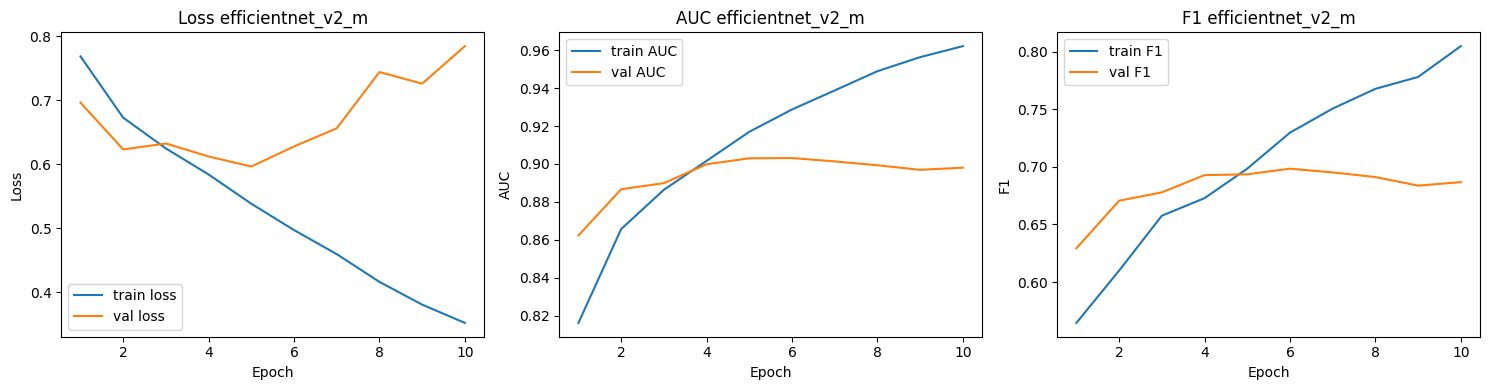

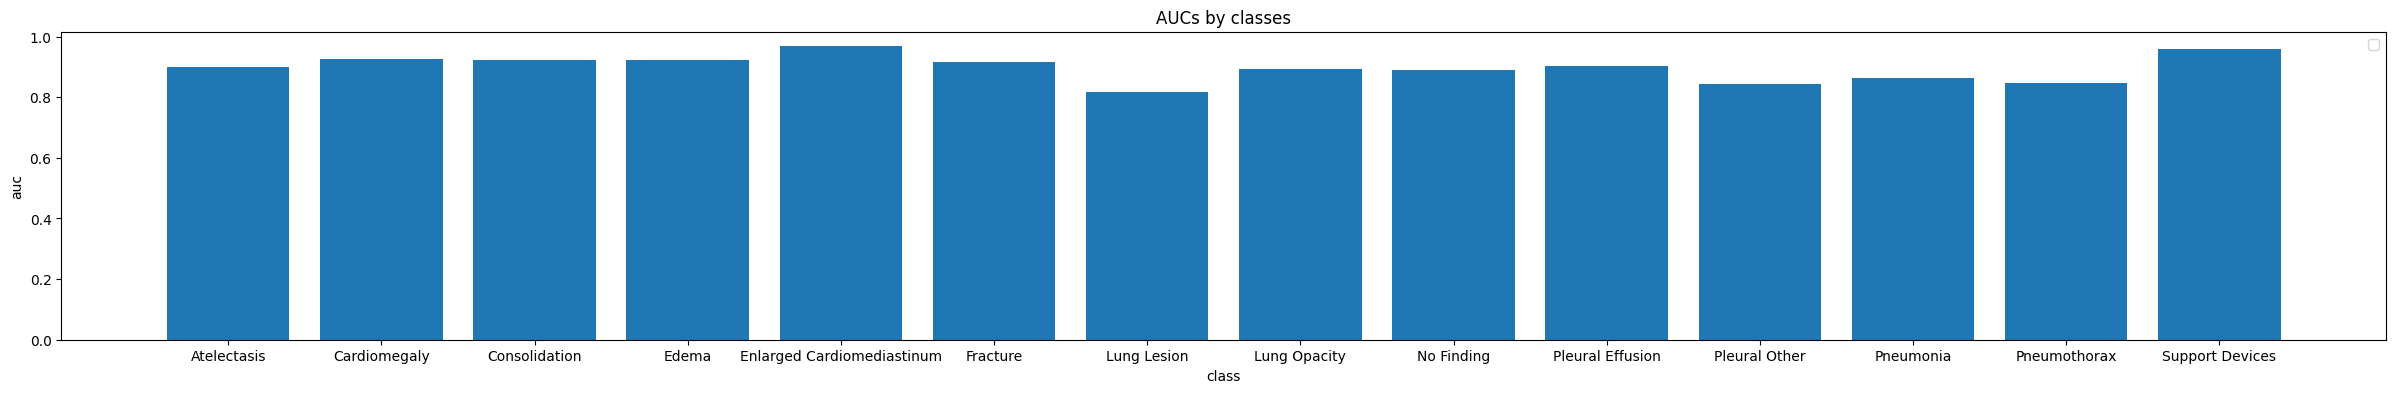

In [ ]:
model_name = 'efficientnet_v2_m'

backbone = models.efficientnet_v2_m(weights="IMAGENET1K_V1")
# take the original first conv
orig_conv = backbone.features[0][0]

# create a new conv with 1 input channel and the same number of output channels
backbone.features[0][0] = nn.Conv2d(
    1,
    orig_conv.out_channels,
    kernel_size=orig_conv.kernel_size,
    stride=orig_conv.stride,
    padding=orig_conv.padding,
    bias=False
)
feature_dim = backbone.classifier[1].in_features
backbone.classifier = nn.Identity()

model = CNNClassifier(backbone, feature_dim=feature_dim, num_classes=NUM_CLASSES)
model.to(DEVICE)

first_layer_params = list(model.backbone.features[0][0].parameters())
other_backbone_params = [p for n, p in model.backbone.named_parameters() 
                         if "features.0.0" not in n]
fc_params = model.fc.parameters()

# optimizer with different LR
optimizer = torch.optim.Adam([
    {'params': first_layer_params, 'lr': 1e-3},
    {'params': other_backbone_params, 'lr': LR},
    {'params': fc_params, 'lr': 1e-3}
])

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
training_and_validation(model_name, model, optimizer, criterion)

In [21]:
torch.save(model, f"{model_name}_full.pth")